## Prediction of Claim Amount in Vehicle Insurance 

In [ ]:
Author: Cosmin Pintoiu
Date: 20 May 2018
e-mail: cosmin.pintoiu@gmail.com

###### Part1: Linear Regression and Random Forest Regressor

# 1. Explore data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv("/opt/datasets/Auto_Insurance_Claims_Sample.csv")

In [3]:
df.describe()

,Claim Amount,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,800.494047,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,687.096761,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,189.800768,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,399.425179,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,578.018220,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,896.216704,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,8332.538119,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


In [4]:
df.head(5)

,Customer,Country,State Code,State,Claim Amount,Response,Coverage,Education,Effective To Date,EmploymentStatus,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Claim Reason,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,US,KS,Kansas,276.351928,No,Basic,Bachelor,2/24/11,Employed,...,5,0,1,Corporate Auto,Corporate L3,Collision,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,US,NE,Nebraska,697.953590,No,Extended,Bachelor,1/31/11,Unemployed,...,42,0,8,Personal Auto,Personal L3,Scratch/Dent,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,US,OK,Oklahoma,1288.743165,No,Premium,Bachelor,2/19/11,Employed,...,38,0,2,Personal Auto,Personal L3,Collision,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,US,MO,Missouri,764.586183,No,Basic,Bachelor,1/20/11,Unemployed,...,65,0,7,Corporate Auto,Corporate L2,Collision,Call Center,529.881344,SUV,Medsize
4,HB64268,US,KS,Kansas,281.369258,No,Basic,Bachelor,2/3/11,Employed,...,44,0,1,Personal Auto,Personal L1,Collision,Agent,138.130879,Four-Door Car,Medsize


In [5]:
# detect missing values
pd.isnull(df).values.any()

False

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 26 columns):
Customer                         9134 non-null object
Country                          9134 non-null object
State Code                       9134 non-null object
State                            9134 non-null object
Claim Amount                     9134 non-null float64
Response                         9134 non-null object
Coverage                         9134 non-null object
Education                        9134 non-null object
Effective To Date                9134 non-null object
EmploymentStatus                 9134 non-null object
Gender                           9134 non-null object
Income                           9134 non-null int64
Location Code                    9134 non-null object
Marital Status                   9134 non-null object
Monthly Premium Auto             9134 non-null int64
Months Since Last Claim          9134 non-null int64
Months Since Policy Inception  

### there are a lot of categorical values, we should look at them

In [7]:
# droping Customer 
df2 = df.drop(['Customer'], axis=1)

cat_features = list(df2.select_dtypes(include=['object']).columns)
print "categorical values: {}".format(len(cat_features))

cat_uniques = []
for cat in cat_features:
    cat_uniques.append(len(df2[cat].unique()))

uv = pd.DataFrame.from_items([('cat_names', cat_features), ('unique_values', cat_uniques)])
#uv.head(18).T
uv.head(18)

categorical values: 17


,cat_names,unique_values
0,Country,1
1,State Code,5
2,State,5
3,Response,2
4,Coverage,3
5,Education,5
6,Effective To Date,59
7,EmploymentStatus,5
8,Gender,2
9,Location Code,3


Populating the interactive namespace from numpy and matplotlib


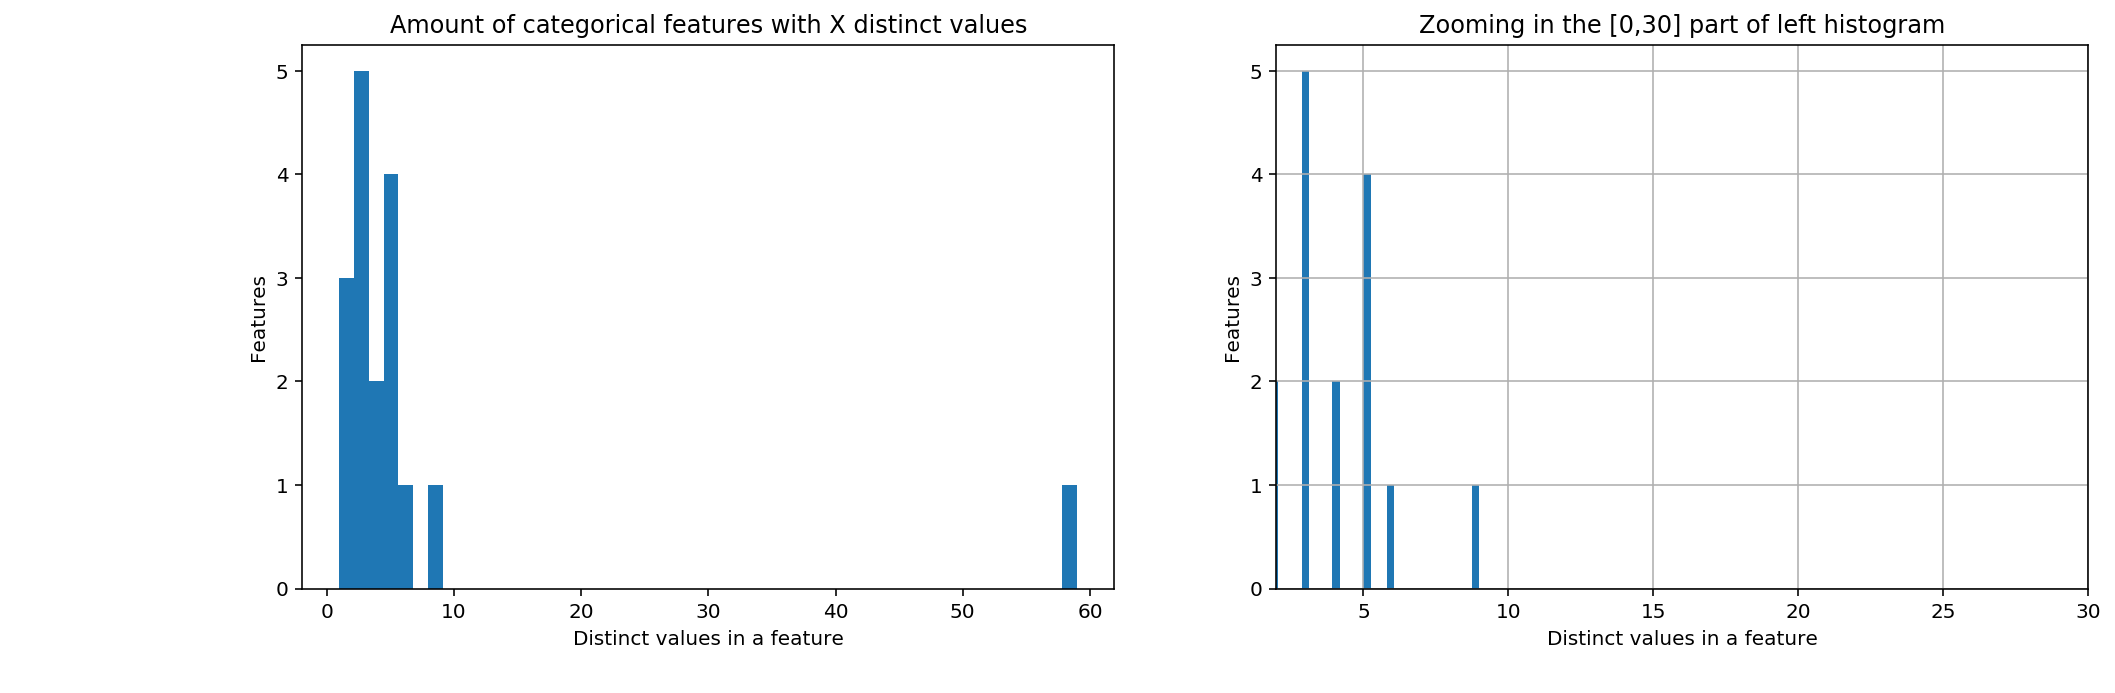

In [8]:
#%matplot inline
%pylab inline

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(uv.unique_values, bins=50)
ax1.set_title('Amount of categorical features with X distinct values')
ax1.set_xlabel('Distinct values in a feature')
ax1.set_ylabel('Features')

ax2.set_xlim(2,30)
ax2.set_title('Zooming in the [0,30] part of left histogram')
ax2.set_xlabel('Distinct values in a feature')
ax2.set_ylabel('Features')
ax2.grid(True)
ax2.hist(uv[uv.unique_values <= 30].unique_values, bins=30)
ax2.annotate('Binary features', xy=(3, 71), xytext=(7, 71), arrowprops=dict(facecolor='black'))

# 2. Analyze continuous features and their distribution

Continuous: 8 features


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f06105814d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0608af0890>]], dtype=object)

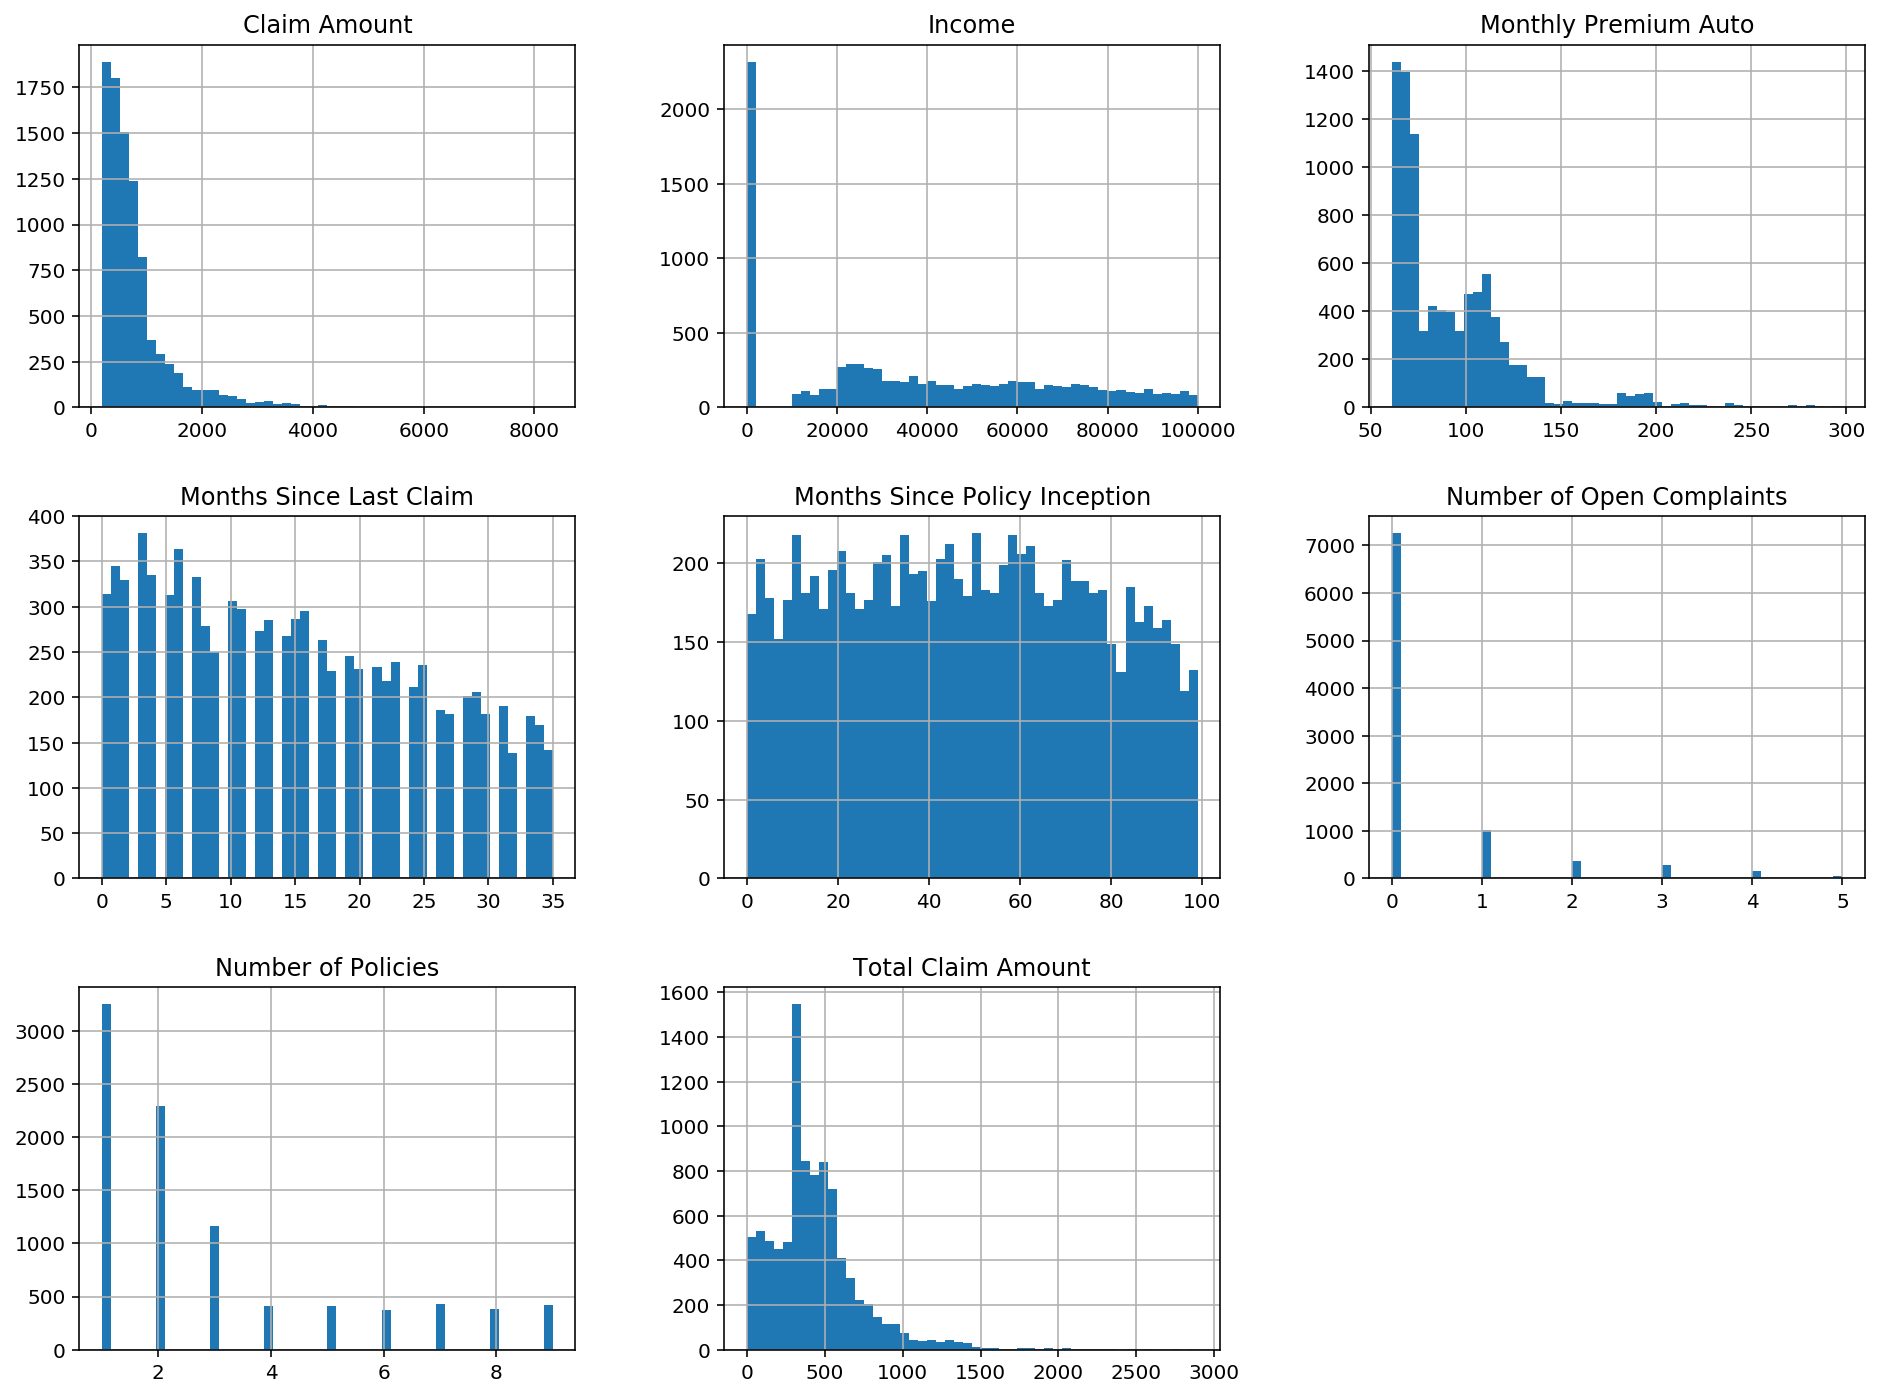

In [9]:
# analyze continuous features and their districution
cont_features = [cont for cont in list(df.select_dtypes(
                 include=['float64', 'int64']).columns)]
print "Continuous: {} features".format(len(cont_features))
df[cont_features].hist(bins=50, figsize=(16,12))

### Vizualize correlation among numerical values

/opt/cloudera/parcels/Anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


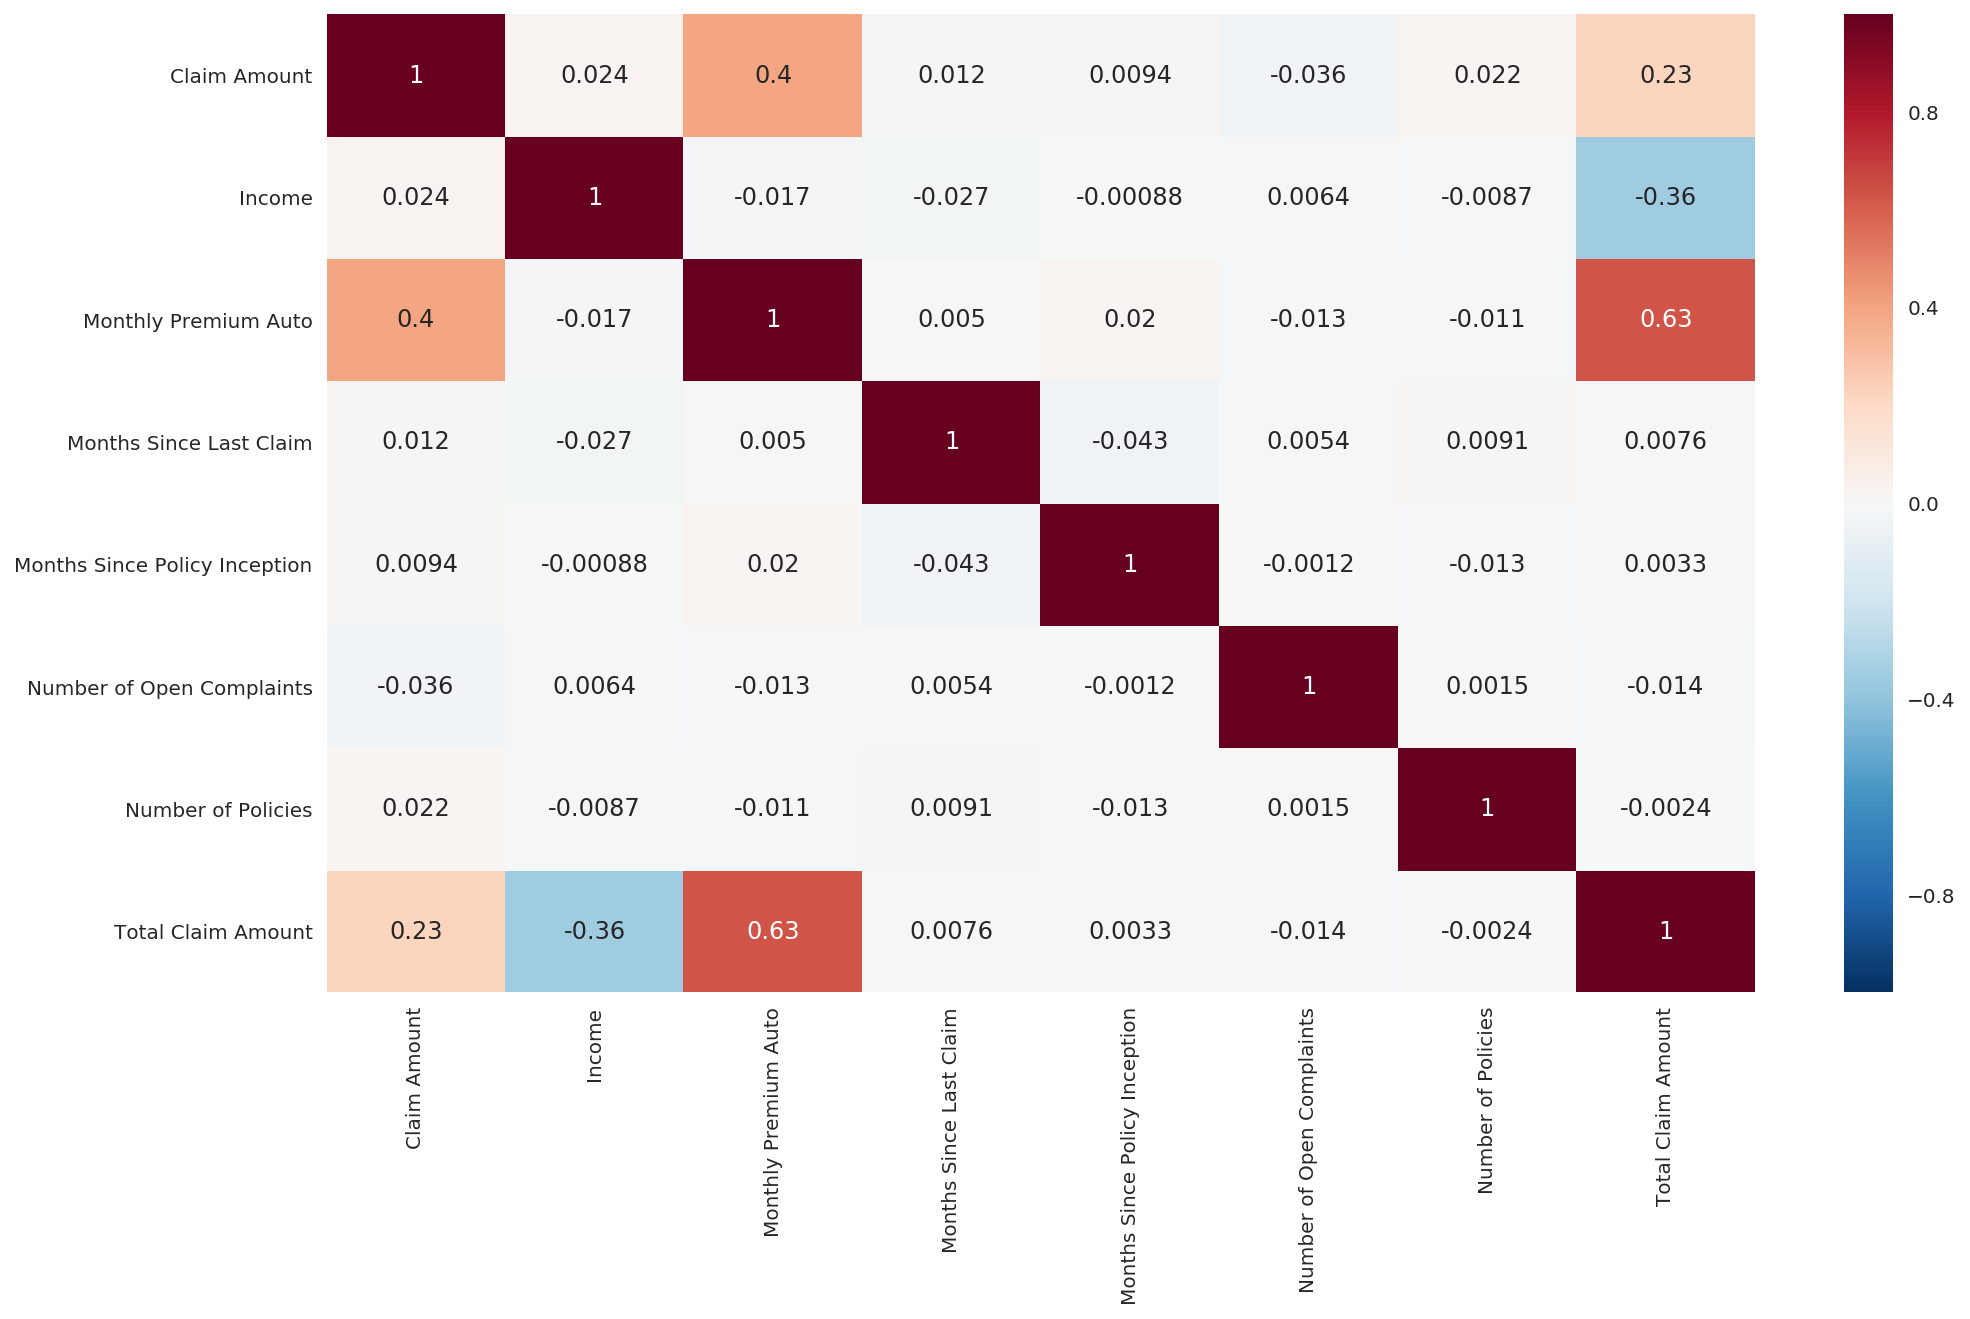

In [10]:
import seaborn as sns
plt.subplots(figsize=(16,9))
correlation_mat = df2[cont_features].corr()
sns.heatmap(correlation_mat, annot=True)

# 3. Target Feature

In [11]:
# adding ID column
dfID = df.drop(['Customer'], axis=1)
dfID['ID'] = range(1, len(df2) + 1)

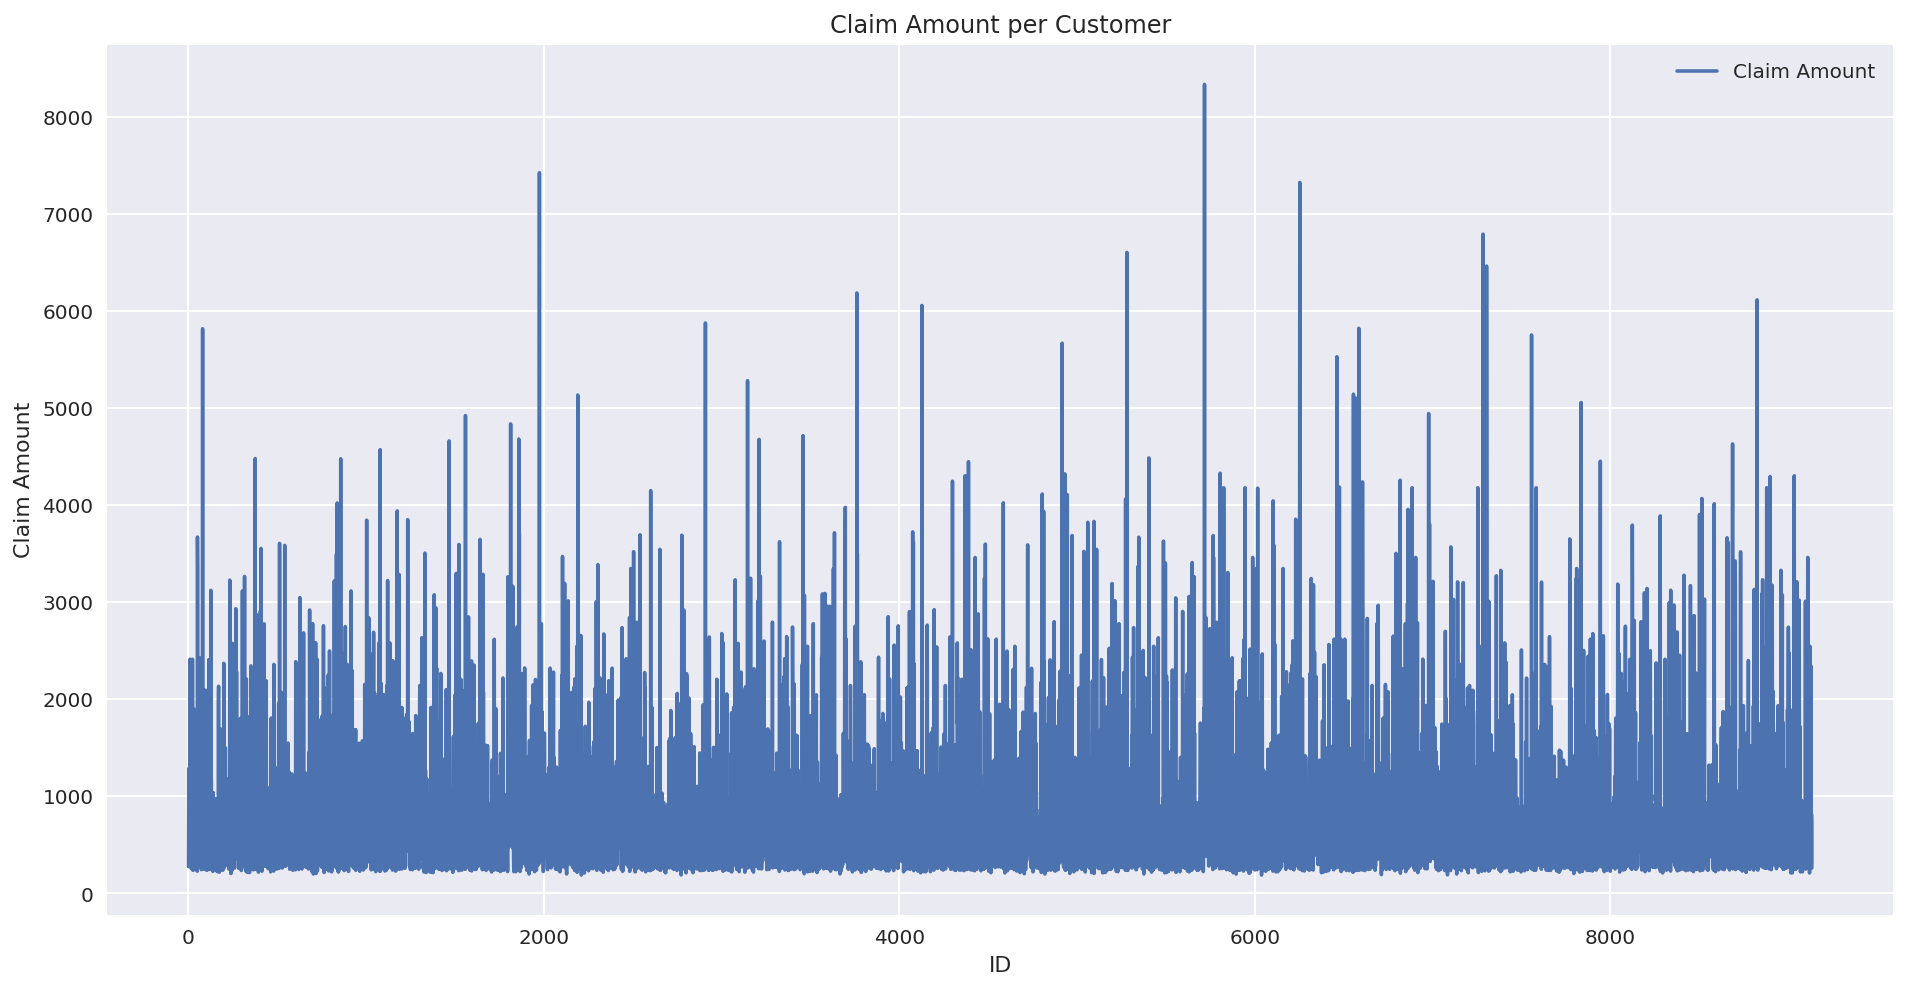

In [12]:
# pick the target feature: claim amount ?
plt.figure(figsize=(16,8))
plt.plot(dfID['ID'], dfID['Claim Amount'])
plt.title('Claim Amount per Customer')
plt.xlabel('ID')
plt.ylabel('Claim Amount')
plt.legend()
plt.show()

In [13]:
# take a look at data sorted distribution
def f(x):
    dfd = x.copy()
    dfd['year'] = pd.DatetimeIndex(x['Effective To Date']).year
    dfd['month'] = pd.DatetimeIndex(x['Effective To Date']).month
    dfd['day'] = pd.DatetimeIndex(x['Effective To Date']).day
    return dfd
df2 = f(df2)
#df2.head()

In [14]:
# transform effective to date
import datetime
years = df2['year']
months = df2['month']
days = df2['day']

dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months,days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
dates.sort()
#print dates

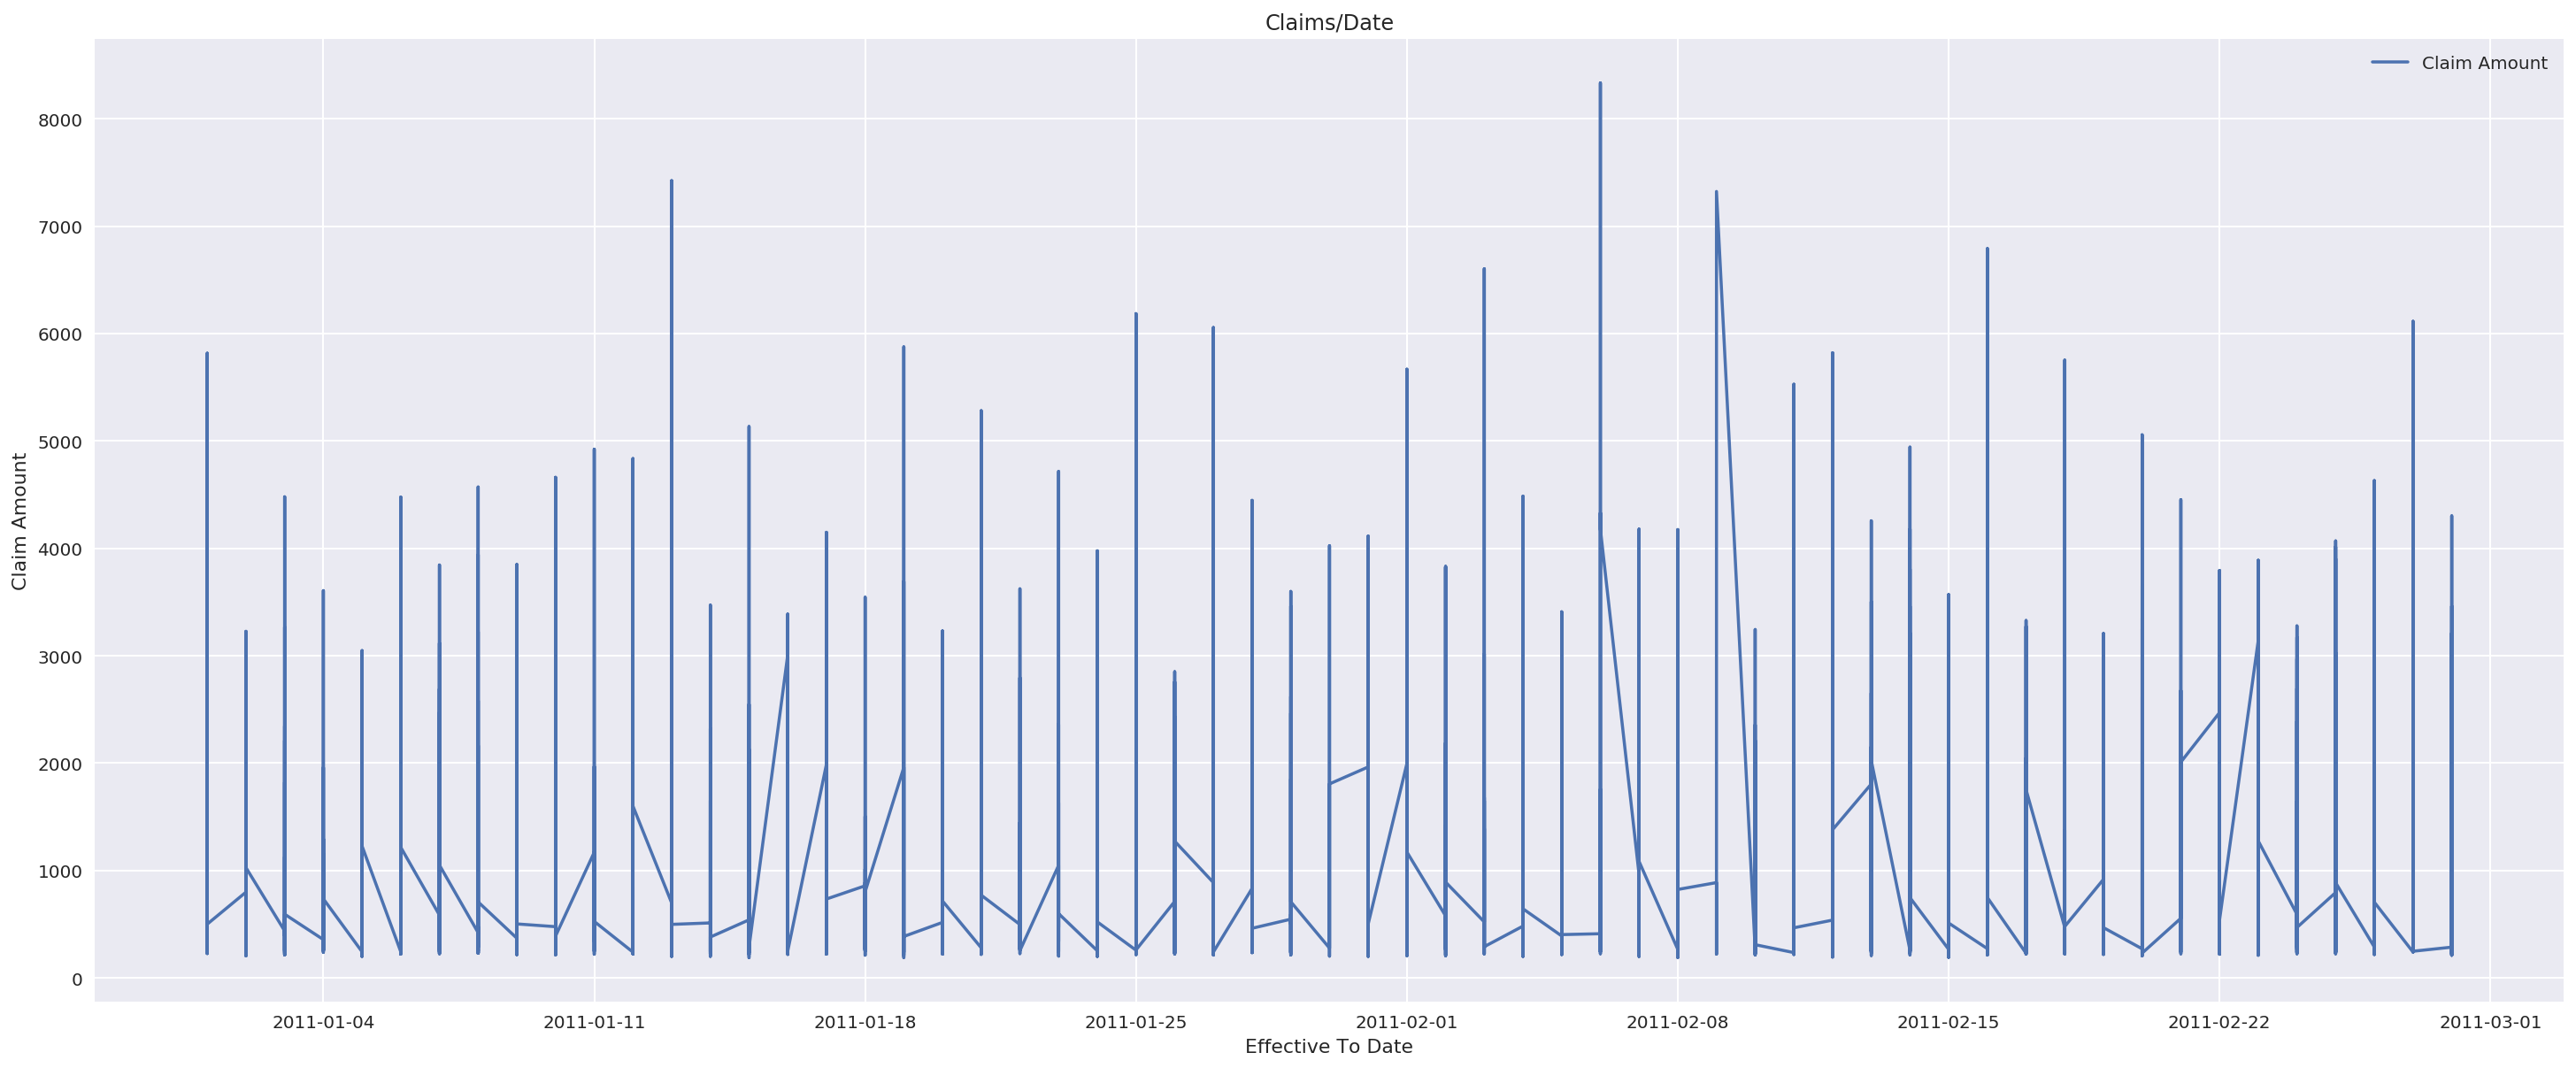

In [15]:
# pick the target feature: claim amount ?

plt.figure(figsize=(25,10))
plt.plot(dates, df2['Claim Amount'])
plt.title('Claims/Date')
plt.xlabel('Effective To Date')
plt.ylabel('Claim Amount')
plt.legend()
plt.show()

In [16]:
# here we can observe some peaks that represent large claim amounts, meaning severe accidents.

In [17]:
from scipy import stats
stats.mstats.skew(np.log(df2['Claim Amount'])).data

array(0.5758461286878797)

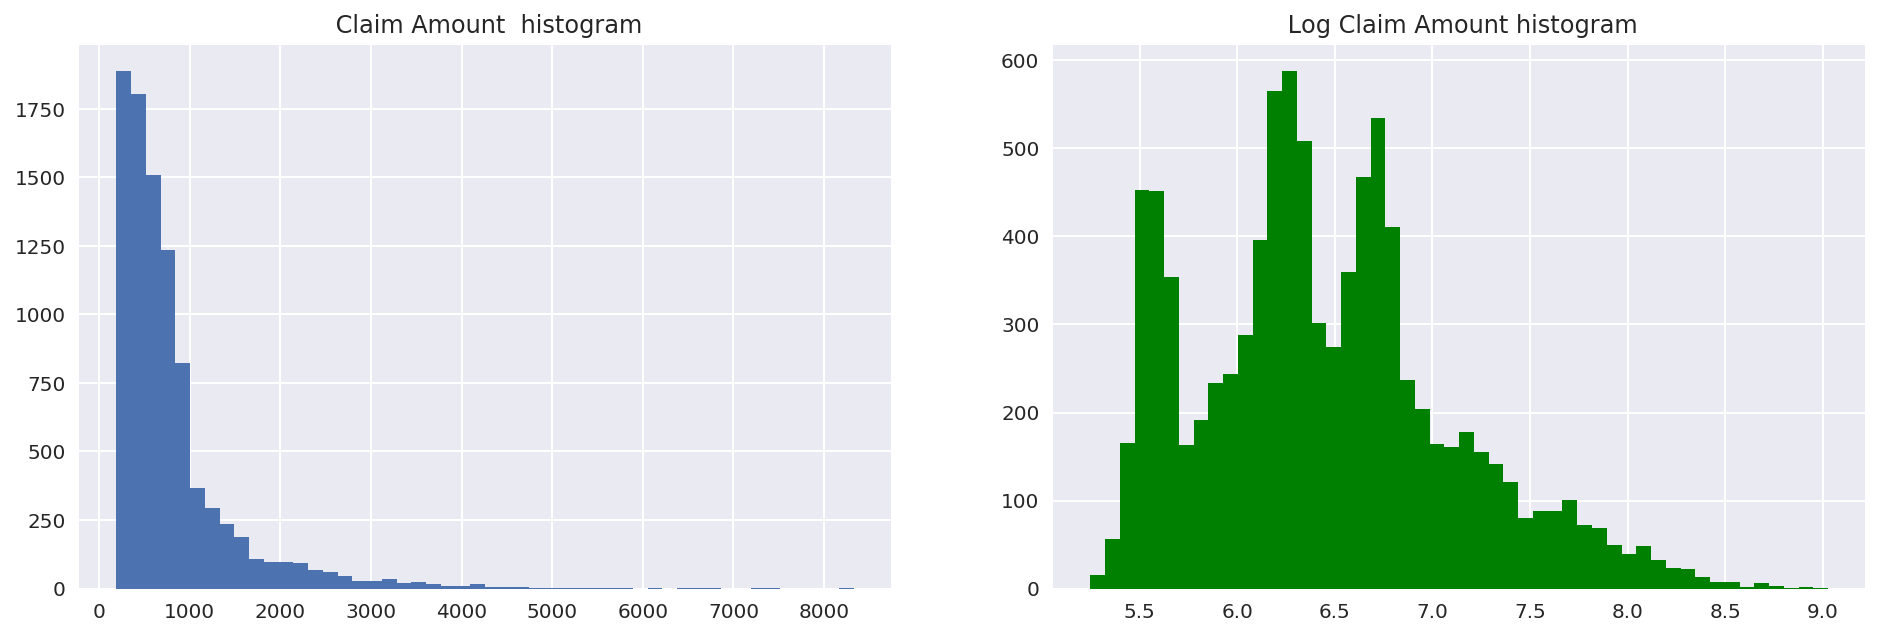

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(df2['Claim Amount'], bins=50)
ax1.set_title(' Claim Amount  histogram')
ax1.grid(True)
ax2.hist(np.log(df2['Claim Amount']), bins=50, color='g')
ax2.set_title(' Log Claim Amount histogram')
ax2.grid(True)
plt.show()

# 4. Encoding categorical values

In [19]:
#cpy object features in new df
obj_df = df2.select_dtypes(include=['object']).copy()
obj_df.head(5)
obj_df.describe()
df2.dtypes

Country                           object
State Code                        object
State                             object
Claim Amount                     float64
Response                          object
Coverage                          object
Education                         object
Effective To Date                 object
EmploymentStatus                  object
Gender                            object
Income                             int64
Location Code                     object
Marital Status                    object
Monthly Premium Auto               int64
Months Since Last Claim            int64
Months Since Policy Inception      int64
Number of Open Complaints          int64
Number of Policies                 int64
Policy Type                       object
Policy                            object
Claim Reason                      object
Sales Channel                     object
Total Claim Amount               float64
Vehicle Class                     object
Vehicle Size    

In [20]:
#df2.head(3)

In [21]:
df2['Response'].value_counts()

No     7826
Yes    1308
Name: Response, dtype: int64

In [22]:
df2['Response'] = df['Response'].apply(lambda x:1 if x=='Yes' else 0)

In [23]:
df2['Coverage'].value_counts()

Basic       5568
Extended    2742
Premium      824
Name: Coverage, dtype: int64

In [24]:
# label encoder
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()

df2["Education_code"] = lb_make.fit_transform(df2["Education"])
df2.append(df2["Education_code"])
df2["EmploymentStatus_code"] = lb_make.fit_transform(df2["EmploymentStatus"])
df2.append(df2["EmploymentStatus_code"])
df2["Gender_code"] = lb_make.fit_transform(df2["Gender"])
df2.append(df2["Gender_code"])
df2["Marital Status code"] = lb_make.fit_transform(df2["Marital Status"])
df2.append(df2["Marital Status code"])
df2["Policy Type code"] = lb_make.fit_transform(df2["Policy Type"])
df2.append(df2["Policy Type code"])
# rf does not accept string ( as in category )
df2["State_code"] = lb_make.fit_transform(df2["State"])
df2.append(df2["State"])
df2["Country_code"] = lb_make.fit_transform(df2["Country"])
df2.append(df2["Country_code"])
df2["Coverage_code"] = lb_make.fit_transform(df2["Coverage"])
df2.append(df2["Coverage_code"])
df2["Location_code"] = lb_make.fit_transform(df2["Location Code"])
df2.append(df2["Location_code"])

#apply changes to df
#df2.append(df2["EmploymentStatus_code", "Gender_code", "Marital Status code", "Policy Type code"])

df2[["Education_code","EmploymentStatus_code", "Gender_code",
     "Marital Status code", "Policy Type code", "State_code", "Country_code", "Coverage_code", "Location_code"]].head(20)


,Education_code,EmploymentStatus_code,Gender_code,Marital Status code,Policy Type code,State_code,Country_code,Coverage_code,Location_code
0,0,1,0,1,0,1,0,0,1
1,0,4,0,2,1,3,0,1,1
2,0,1,0,1,1,4,0,2,1
3,0,4,1,1,0,2,0,0,1
4,0,1,1,2,1,1,0,0,0
5,0,1,0,1,1,0,0,0,0
6,1,1,0,1,0,0,0,0,1
7,4,4,1,2,0,3,0,2,2
8,0,2,1,0,0,0,0,0,1
9,1,1,0,1,2,0,0,1,2


In [25]:
# drop encoded columns
df2 = df2.drop(["Education","EmploymentStatus", "Gender", "Marital Status", "Policy Type"], axis=1)
df2 = df2.drop(["Effective To Date"], axis=1)
df2 = df2.drop(["State Code"], axis=1)
df2 = df2.drop(["State", "Country", "Coverage", "Location Code"], axis = 1)

In [26]:
#LabelBinarizer
df2['Policy'].value_counts()

Personal L3     3426
Personal L2     2122
Personal L1     1240
Corporate L3    1014
Corporate L2     595
Corporate L1     359
Special L2       164
Special L3       148
Special L1        66
Name: Policy, dtype: int64

In [27]:
# label binarizer
from sklearn.preprocessing import LabelBinarizer

lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(df2["Policy"])
lb_results

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [28]:
# one hot encoder
df2 = pd.get_dummies(data=df2, columns=["Policy","Claim Reason", "Sales Channel", "Vehicle Class", "Vehicle Size"])
df2.head(3)

,Claim Amount,Response,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,year,...,Sales Channel_Web,Vehicle Class_Four-Door Car,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Large,Vehicle Size_Medsize,Vehicle Size_Small
0,276.351928,0,56274,69,32,5,0,1,384.811147,2011,...,0,0,0,0,0,0,1,0,1,0
1,697.953590,0,0,94,13,42,0,8,1131.464935,2011,...,0,1,0,0,0,0,0,0,1,0
2,1288.743165,0,48767,108,18,38,0,2,566.472247,2011,...,0,0,0,0,0,0,1,0,1,0


In [29]:
# last thing to do on the data is to change float data type as RF does not accept at this time. (could be long)
df2[["Claim Amount", "Total Claim Amount"]] = df2[["Claim Amount", "Total Claim Amount"]].astype(int)

In [30]:
df2.dtypes

Claim Amount                     int64
Response                         int64
Income                           int64
Monthly Premium Auto             int64
Months Since Last Claim          int64
Months Since Policy Inception    int64
Number of Open Complaints        int64
Number of Policies               int64
Total Claim Amount               int64
year                             int64
month                            int64
day                              int64
Education_code                   int64
EmploymentStatus_code            int64
Gender_code                      int64
Marital Status code              int64
Policy Type code                 int64
State_code                       int64
Country_code                     int64
Coverage_code                    int64
Location_code                    int64
Policy_Corporate L1              uint8
Policy_Corporate L2              uint8
Policy_Corporate L3              uint8
Policy_Personal L1               uint8
Policy_Personal L2       

# 5. Split training and test data

In [31]:
from sklearn.model_selection import train_test_split
#trainingSet, testSet = train_test_split(df2, test_size=0.4)

labels = np.array(df2['Claim Amount'])
features = df2.drop(['Claim Amount'], axis = 1)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.30, random_state = 42)


In [32]:
#testSet = testSet.drop(["Claim Amount"], axis=1)
print('train f', train_features.shape)
print('train l', train_labels.shape)
print('test f', test_features.shape)
print('test l', test_labels.shape)

('train f', (6393, 46))
('train l', (6393,))
('test f', (2741, 46))
('test l', (2741,))


# 6.  Create the models and run predictions

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.cross_validation import cross_val_score

/opt/cloudera/parcels/Anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [34]:
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
#rf = RandomForestClassifier()
lr = linear_model.LinearRegression()

### A. LinearRegression 

In [216]:
#target = trainingSet["Claim Amount"]

In [35]:
model1 = lr.fit(train_features, train_labels)

In [36]:
predictions = lr.predict(test_features)
print predictions

[  935.93965365   591.34332818   727.25516382 ...,  1152.78596447
   596.73992398  1071.63913954]


In [37]:
errors = abs(predictions - test_labels)
print errors
print('mean absolut error is: ', round(np.mean(errors),2), '$')

[  513.93965365    40.34332818   347.25516382 ...,   600.78596447
    87.73992398  1847.36086046]
('mean absolut error is: ', 402.02, '$')


In [38]:
mape = 100 * (errors / test_labels)
print mape

accuracy = 100 - np.mean(mape)
print ('Accuracy: ', round(accuracy,2), '%.')

[ 121.78664778    7.32183815   91.38293785 ...,  108.83803704   17.23770609
   63.28745668]
('Accuracy: ', 39.44, '%.')


In [39]:
print "Score:", model1.score(test_features, test_labels)

Score: 0.155983416573


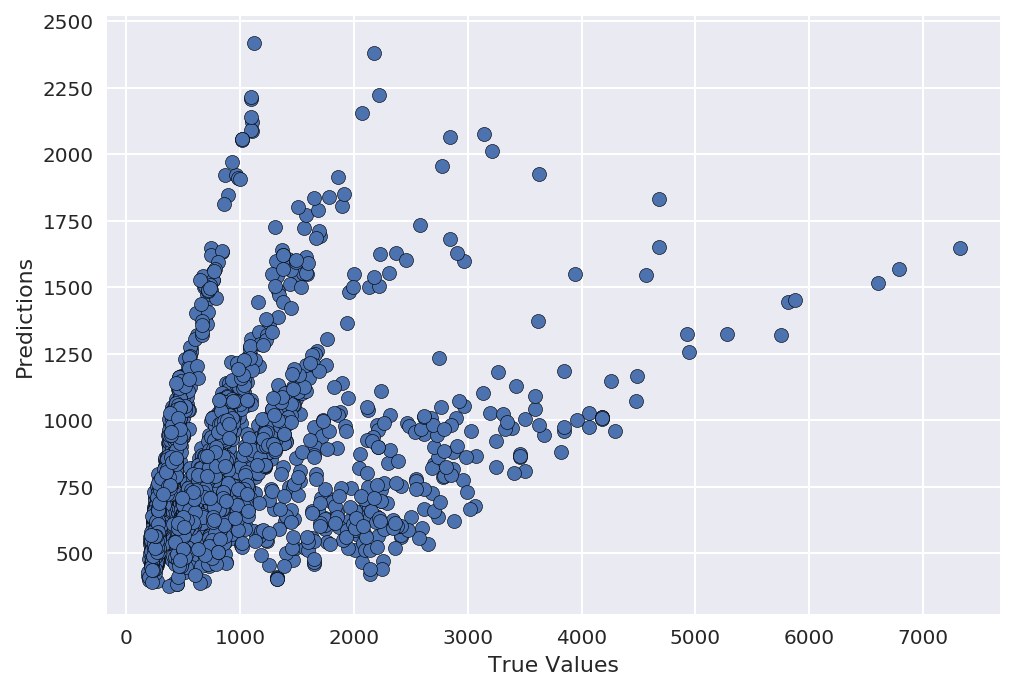

In [40]:
plt.scatter(test_labels, predictions,  edgecolors=(0, 0, 0))
plt.xlabel("True Values")
plt.ylabel("Predictions")

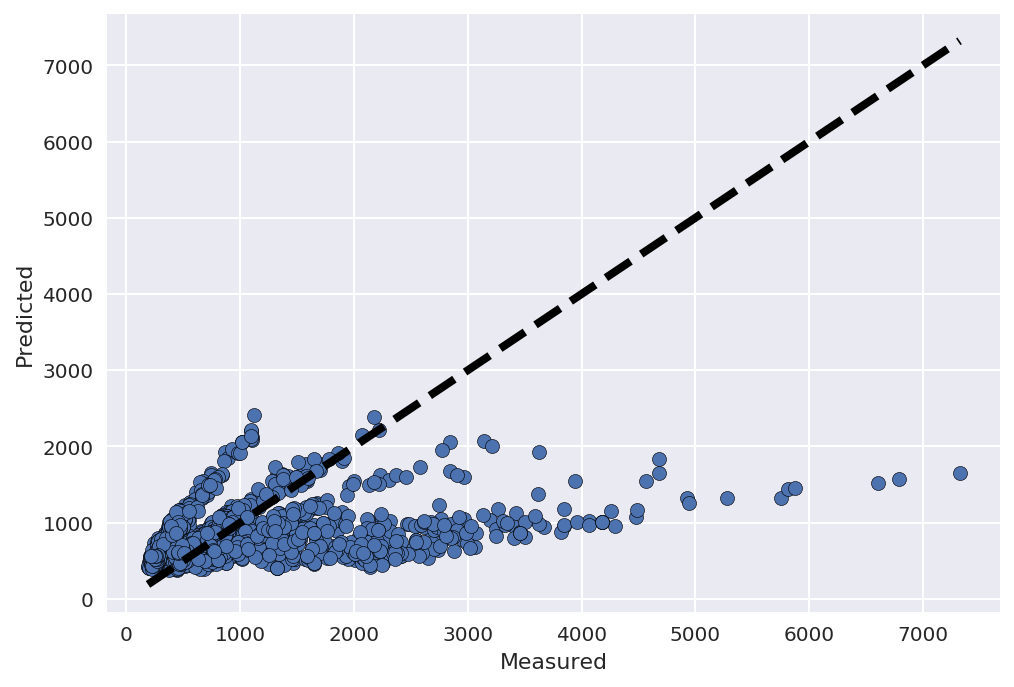

In [41]:
fig, ax = plt.subplots()
ax.scatter(test_labels, predictions, edgecolors=(0, 0, 0))
ax.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### B.  RandomForest Regressor

In [42]:
model2 = rf.fit(train_features, train_labels)

In [43]:
predictions2 = rf.predict(test_features)
print predictions2[1:100]

[  545.7   379.4   785.4  1129.5  1109.2   538.2   520.9   477.4   529.4
   746.    844.8   532.9   339.4   502.8   778.4  1717.8  1965.2   224.7
   562.    223.    377.8   255.9   607.7  1288.7   242.3   355.2  1540.1
   257.   1327.2   288.8   804.    284.1   263.    598.2   552.8   613.6
  2778.    564.8   287.5  1377.    265.5   383.3   518.4   869.9   244.4
   275.1   664.2   310.7  1290.1  1033.3   502.5  2134.6   541.5   234.5
   218.1   461.5  2426.3   847.3   829.3   279.2   368.2  1095.3   321.2
   956.4  1238.3   535.5   247.    901.8   518.4   713.4   729.5   248.4
   578.5   934.4   290.7   529.5   273.9   537.8  1195.    743.5   938.1
   836.7  1486.5   397.3   624.2   536.4   264.2   396.4   898.1   883.7
   552.9   224.7  1036.2  1109.2   550.8  1160.   1102.6  1095.2  1043.5]


In [44]:
errors2 = abs(predictions2 - test_labels)
print errors2[1:100]
print('mean absolut error is: ', round(np.mean(errors2),2), '$')

[  5.30000000e+00   6.00000000e-01   5.60000000e+00   3.36500000e+02
   3.23800000e+02   1.78000000e+01   4.39000000e+01   5.40000000e+00
   1.26000000e+01   0.00000000e+00   3.80000000e+00   9.00000000e-01
   3.60000000e+00   2.00000000e-01   4.00000000e-01   2.12620000e+03
   1.29980000e+03   4.70000000e+00   9.00000000e+00   1.00000000e+00
   2.00000000e-01   1.90000000e+00   1.03000000e+01   4.93700000e+02
   2.70000000e+00   1.52000000e+01   2.08900000e+02   1.10000000e+01
   5.95200000e+02   5.20000000e+00   1.70000000e+01   1.00000000e-01
   4.00000000e+00   2.28000000e+01   8.00000000e-01   1.44000000e+01
   0.00000000e+00   1.12000000e+01   5.00000000e-01   5.00000000e+00
   1.50000000e+00   7.00000000e-01   7.40000000e+00   6.19000000e+01
   4.00000000e-01   1.00000000e-01   1.20000000e+00   1.70000000e+00
   1.44790000e+03   2.33000000e+01   4.50000000e+00   5.71400000e+02
   9.50000000e+00   2.50000000e+00   4.90000000e+00   7.50000000e+00
   4.16700000e+02   3.00000000e-01

In [45]:
# Mean absolute percentage error
mape2 = 100 * (errors2 / test_labels)
#print mape2[1:100]

accuracy2 = 100 - np.mean(mape2)
print ('Accuracy: ', round(accuracy2,2), '%.')

('Accuracy: ', 89.88, '%.')


In [247]:
#print "Score:", model2.score(test_features, test_labels)

In [46]:
from sklearn import metrics
accuracyr2 = metrics.r2_score(test_labels, predictions2)
#print "Cross-Predicted Accuracy:", accuracyr2

In [47]:
sumC = df2["Claim Amount"].sum()
print sumC

7307098


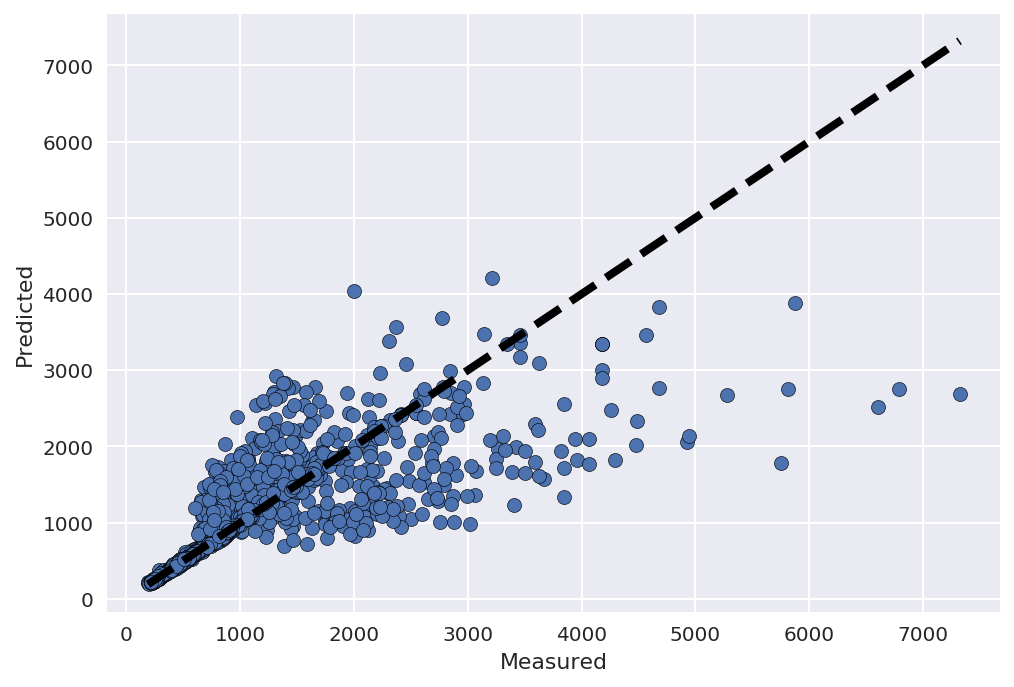

In [48]:
fig, ax = plt.subplots()
ax.scatter(test_labels, predictions2, edgecolors=(0, 0, 0))
ax.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

# 7. Feature importance

In [49]:
features_list = list(df2.columns)

In [50]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance,2)) for feature , importance in zip(features_list, importances)] 
feature_importances = sorted(feature_importances, key = lambda x:x[1], reverse = True)
#[print('variable: {:20} importnace: {}'.format(*pair)) for pair in feature_importances];
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

for pair in feature_importances:
    print('Variable: {:20}                   Importance: {}'.format(*pair))

Variable: Number of Open Complaints                   Importance: 0.46
Variable: Income                                 Importance: 0.26
Variable: month                                  Importance: 0.04
Variable: Monthly Premium Auto                   Importance: 0.03
Variable: Months Since Last Claim                   Importance: 0.03
Variable: Number of Policies                     Importance: 0.03
Variable: Response                               Importance: 0.02
Variable: Claim Amount                           Importance: 0.01
Variable: day                                    Importance: 0.01
Variable: Education_code                         Importance: 0.01
Variable: Policy Type code                       Importance: 0.01
Variable: Coverage_code                          Importance: 0.01
Variable: Sales Channel_Call Center                   Importance: 0.01
Variable: Months Since Policy Inception                   Importance: 0.0
Variable: Total Claim Amount                     Import

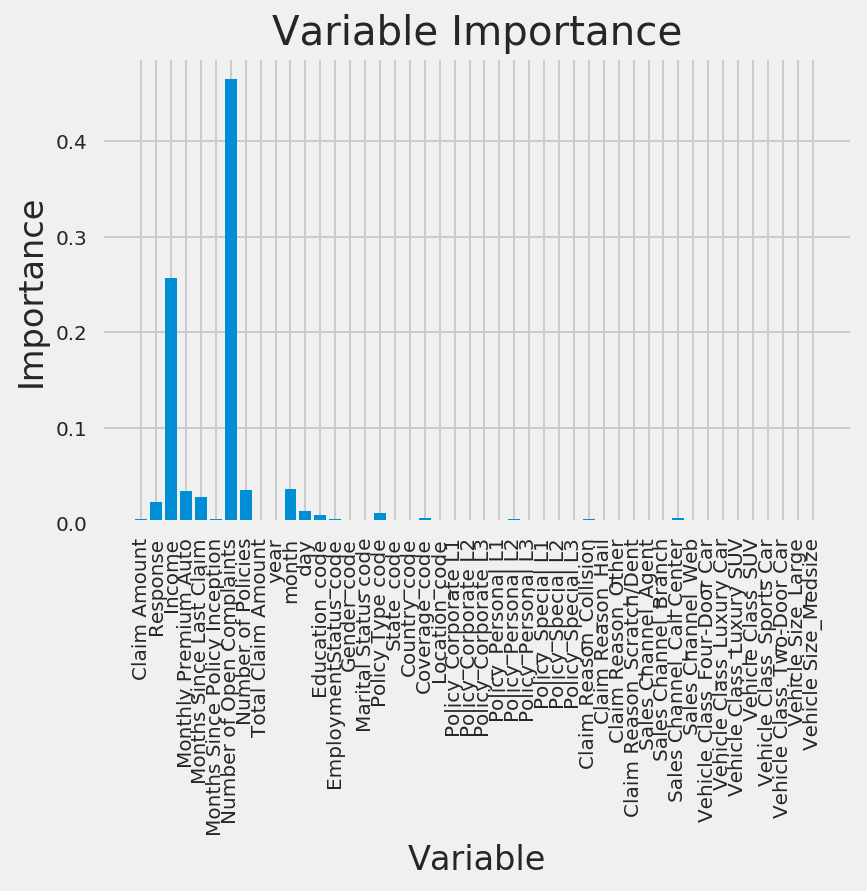

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, features_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable');
plt.title('Variable Importance')